#Autoencoders


##Vanilla autoencoder

An autoencoder is a type of artificial neural network.
It used to learn efficient codings of input data without ground truth information.
It attemps to generate encoded representations of the input data by setting target valus to be equal to inputs.
Thus, it is considered to be an unsupervised learning method.


An autoencoder has two functions:
* Encoder
* Decoder

An encoder that transforms the input data $x$ into a lower dimensional latent representation $z$, and a decoder that reconstructs the input data $\hat{x}$ from the latent representation.
An autoencoder learns to compress the data while minimizing the reconstruction error by comparing $x$ to $\hat{x}$.



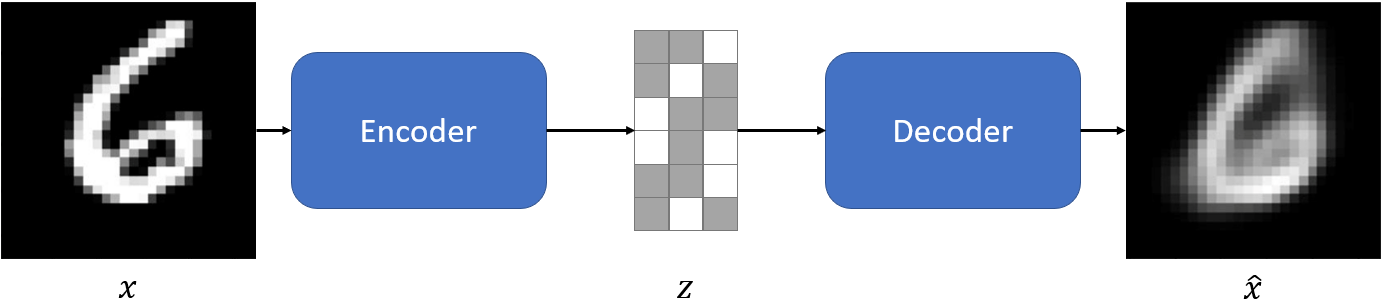

## Perform standard imports

In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


# from torchsummary import summary
# try:
#     from torchinfo import summary
# except:
#     !pip install -q torchinfo
#     from torchinfo import summary
# from sklearn import preprocessing

from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

Using device cpu


In [2]:
import torchvision
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

NUM_CHANNEL = 1

VAL_SIZE = 0.1
BATCH_SIZE = 64
width = 28
height = 28

mnist_train = torchvision.datasets.MNIST(
    '/data/',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([transforms.Resize((width, height)),torchvision.transforms.ToTensor()])
)
mnist_test = torchvision.datasets.MNIST(
    '/data/',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([transforms.Resize((width, height)),torchvision.transforms.ToTensor()])
)


# generate indices: instead of the actual data we pass in integers instead
train_indices, val_indices, _, _ = train_test_split(
    range(len(mnist_train)),
    mnist_train.targets,
    stratify=mnist_train.targets,
    test_size=VAL_SIZE,
)

# generate subset based on indices
train_split = Subset(mnist_train, train_indices)
val_split = Subset(mnist_train, val_indices)

# create batches
Tr_dataloader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
Va_dataloader = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True)
Ts_dataloader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)

Using device cpu


## Building a simple autoencoder

In [ ]:
def train_AE(model, dataloaders, criterion, optimizer, num_epochs=10):
    start = time.time()

    va_loss_history = []
    tr_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val = np.inf

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # Backpropagate only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Gather our summary statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_end = time.time()

            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            print("Epoch time taken: ", elapsed_epoch)

            # If this is the best model on the validation set so far, deep copy it
            if phase == 'val' and epoch_loss < best_val:
                best_val = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                va_loss_history.append(epoch_loss)
            if phase == 'train':
                tr_loss_history.append(epoch_loss)

        print()

    # Output summary statistics, load the best weight set, and return results

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validate Loss: {:4f}'.format(best_val))
    model.load_state_dict(best_model_wts)
    return model, tr_loss_history, va_loss_history


### Fully connected based autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self,**kwargs):
        super(Autoencoder,self).__init__(**kwargs)

        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784)
        )

    def forward(self, x):
        dim = x.shape
        x = self.encoder(x.view(-1, 784))
        x = self.decoder(x)
        x = F.sigmoid(x)
        return x.reshape(dim)

# Move model to target device
model = Autoencoder().to(device)

# Show the details of the network
summary(model, input_size=(NUM_CHANNEL,width,height), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
            Linear-4                  [-1, 256]          33,024
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 784]         201,488
Total params: 468,368
Trainable params: 468,368
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.79
Estimated Total Size (MB): 1.80
----------------------------------------------------------------


Epoch 0/9
----------
train Loss: 0.1498
Epoch time taken:  11.63557505607605
val Loss: 0.0995
Epoch time taken:  12.417686939239502

Epoch 1/9
----------
train Loss: 0.0916
Epoch time taken:  9.034045457839966
val Loss: 0.0859
Epoch time taken:  9.856847286224365

Epoch 2/9
----------
train Loss: 0.0827
Epoch time taken:  8.631125211715698
val Loss: 0.0804
Epoch time taken:  9.937829971313477

Epoch 3/9
----------
train Loss: 0.0783
Epoch time taken:  8.304040670394897
val Loss: 0.0769
Epoch time taken:  9.106720209121704

Epoch 4/9
----------
train Loss: 0.0756
Epoch time taken:  9.058663606643677
val Loss: 0.0748
Epoch time taken:  10.939855098724365

Epoch 5/9
----------
train Loss: 0.0736
Epoch time taken:  11.477003812789917
val Loss: 0.0736
Epoch time taken:  12.26569128036499

Epoch 6/9
----------
train Loss: 0.0723
Epoch time taken:  9.110617399215698
val Loss: 0.0720
Epoch time taken:  9.904585599899292

Epoch 7/9
----------
train Loss: 0.0713
Epoch time taken:  9.132822990417

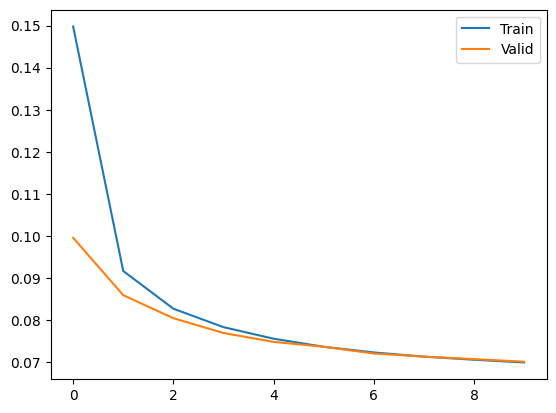

In [ ]:
# criterion = nn.MSELoss()
criterion = nn.BCELoss()

params_to_update = model.parameters()
optimizer = optim.Adam(params_to_update, lr=0.001)
dataloaders = {'train': Tr_dataloader, 'val': Va_dataloader}
model, tr_loss_history, va_loss_history = train_AE(model, dataloaders, criterion, optimizer)

plt.plot(tr_loss_history, label="Train")
plt.plot(va_loss_history, label="Valid")
plt.legend()
plt.show()

In [ ]:
error = 0.0
model.eval()

for inputs, labels in Ts_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    target = model(inputs)
    loss = criterion(target,inputs)
    error += loss.item() * inputs.size(0)

print('Testing error: {:4f}'.format(error/len(Ts_dataloader.dataset)))

Testing error: 0.069414


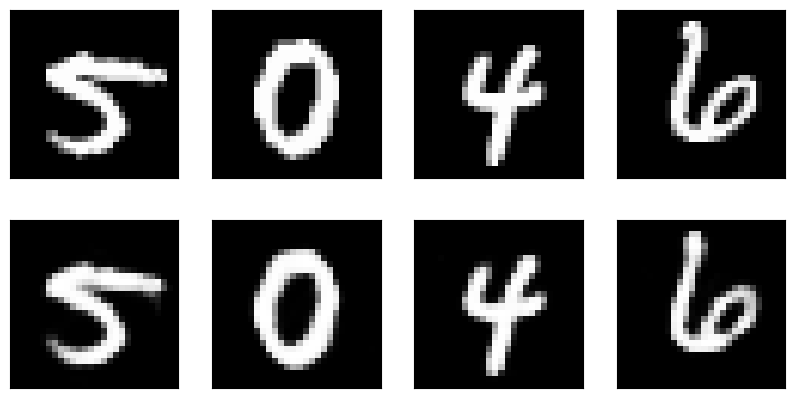

In [ ]:
dataiter = iter(Ts_dataloader)

model.eval()
n = 4
inputs, labels = next(dataiter)
plt.figure(figsize=(10, 5))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(inputs[i].numpy().squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    dim = inputs.shape
    plt.imshow(model(inputs[i].to(device).reshape(1,dim[1],dim[2],dim[3])).detach().cpu().numpy().squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### CNN based autoencoder

####Encoder
The encoder part of the network will be a typical convolutional pyramid.
Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions (downsampling) of the layers.
Both pooling and strided convolution can be used to downsample the image.

####Decoder
The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide, reconstructed image.
This decoder uses transposed convolutional layers to increase the width and height of its input feature. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. PyTorch provides us with an easy way to create the layers, [nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).



In [ ]:
from torch import nn
import torch

input = torch.randn(20, 3, 32, 32)

m = nn.Conv2d(3, 8, 3, padding=1)
output = m(input)
print(f"The output shape of nn.Conv2d:\t\t {output.shape}")

m = nn.ConvTranspose2d(3, 8, 2, stride=2)
output = m(input)
print(f"The output shape of nn.ConvTranspose2d:\t {output.shape}")

The output shape of nn.Conv2d:		 torch.Size([20, 8, 32, 32])
The output shape of nn.ConvTranspose2d:	 torch.Size([20, 8, 64, 64])


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self,**kwargs):
        super(Autoencoder,self).__init__(**kwargs)
        self.encoder = nn.Sequential(
            nn.Conv2d(NUM_CHANNEL, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, NUM_CHANNEL, 2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Move model to target device
model = Autoencoder().to(device)

# Show the details of the network
summary(model, input_size=(NUM_CHANNEL,width,height), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4            [-1, 8, 14, 14]           1,160
              ReLU-5            [-1, 8, 14, 14]               0
         MaxPool2d-6              [-1, 8, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]             528
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 1,913
Trainable params: 1,913
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.01
Estimated Total

Epoch 0/9
----------
train Loss: 0.1920
Epoch time taken:  9.44542646408081
val Loss: 0.1033
Epoch time taken:  10.2623131275177

Epoch 1/9
----------
train Loss: 0.0997
Epoch time taken:  9.496809959411621
val Loss: 0.0972
Epoch time taken:  10.303298234939575

Epoch 2/9
----------
train Loss: 0.0955
Epoch time taken:  8.673052072525024
val Loss: 0.0941
Epoch time taken:  9.896322250366211

Epoch 3/9
----------
train Loss: 0.0931
Epoch time taken:  8.840891361236572
val Loss: 0.0922
Epoch time taken:  9.669018507003784

Epoch 4/9
----------
train Loss: 0.0916
Epoch time taken:  9.512621879577637
val Loss: 0.0909
Epoch time taken:  10.31739068031311

Epoch 5/9
----------
train Loss: 0.0903
Epoch time taken:  9.302661895751953
val Loss: 0.0898
Epoch time taken:  10.121479272842407

Epoch 6/9
----------
train Loss: 0.0894
Epoch time taken:  9.418092489242554
val Loss: 0.0889
Epoch time taken:  10.233845233917236

Epoch 7/9
----------
train Loss: 0.0886
Epoch time taken:  8.83652257919311

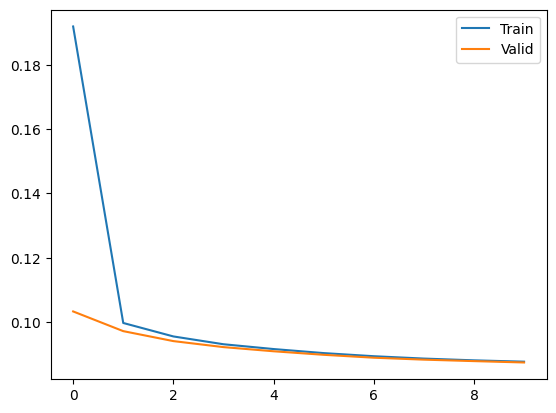

In [ ]:
# criterion = nn.MSELoss()
criterion = nn.BCELoss()

params_to_update = model.parameters()
optimizer = optim.Adam(params_to_update, lr=0.001)
dataloaders = {'train': Tr_dataloader, 'val': Va_dataloader}
model, tr_loss_history, va_loss_history = train_AE(model, dataloaders, criterion, optimizer)

plt.plot(tr_loss_history, label="Train")
plt.plot(va_loss_history, label="Valid")
plt.legend()
plt.show()

In [ ]:
error = 0.0
model.eval()
for inputs, labels in Ts_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    target = model(inputs)
    loss = criterion(target,inputs)
    error += loss.item() * inputs.size(0)

print('Testing error: {:4f}'.format(error/len(Ts_dataloader.dataset)))

Testing error: 0.086527


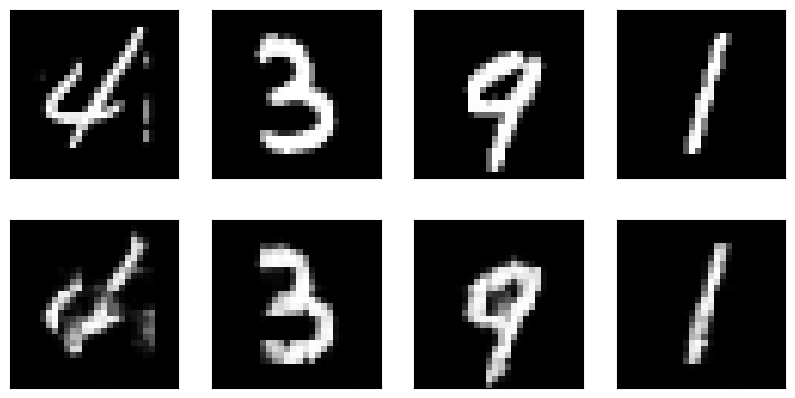

In [ ]:
dataiter = iter(Ts_dataloader)

model.eval()
n = 4
inputs, labels = next(dataiter)
plt.figure(figsize=(10, 5))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(inputs[i].numpy().squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    dim = inputs.shape
    plt.imshow(model(inputs[i].to(device).reshape(1,dim[1],dim[2],dim[3])).detach().cpu().numpy().squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##Denoise autoencoder

A Denoise Autoencoder is a modification on the autoencoder to prevent the network learning the identity function. Specifically, if the autoencoder is too big, then it can just learn the data, so the output equals the input, and does not perform any useful representation learning or dimensionality reduction. Denoise autoencoders solve this problem by corrupting the input data on purpose, adding noise or masking some of the input values.

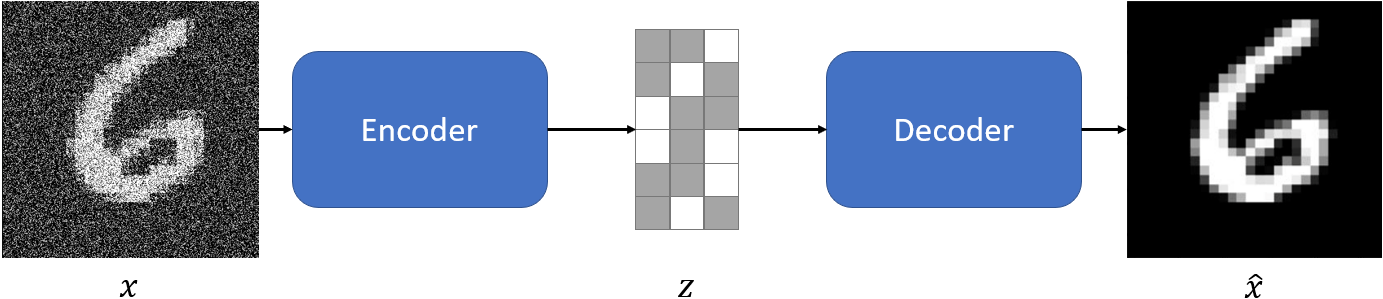

In [ ]:
from skimage.util import random_noise

In [ ]:
class DenoiseAutoencoder(nn.Module):
    def __init__(self,**kwargs):
        super(DenoiseAutoencoder,self).__init__(**kwargs)

        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784)
        )

    def forward(self, x):
        dim = x.shape
        if self.training:
            x = x + torch.randn(dim).to(device) * 0.25
        x = x.view(-1, 784)
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.sigmoid(x)
        return x.reshape(dim)

# Move model to target device
model = DenoiseAutoencoder().to(device)

# Show the details of the network
summary(model, input_size=(NUM_CHANNEL,width,height), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
            Linear-4                  [-1, 256]          33,024
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 784]         201,488
Total params: 468,368
Trainable params: 468,368
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.79
Estimated Total Size (MB): 1.80
----------------------------------------------------------------


Epoch 0/9
----------
train Loss: 0.1562
Epoch time taken:  10.52641487121582
val Loss: 0.1028
Epoch time taken:  11.352383613586426

Epoch 1/9
----------
train Loss: 0.1012
Epoch time taken:  9.53362488746643
val Loss: 0.0885
Epoch time taken:  10.312043905258179

Epoch 2/9
----------
train Loss: 0.0930
Epoch time taken:  9.756036520004272
val Loss: 0.0834
Epoch time taken:  10.549036026000977

Epoch 3/9
----------
train Loss: 0.0896
Epoch time taken:  8.644497156143188
val Loss: 0.0808
Epoch time taken:  9.749560356140137

Epoch 4/9
----------
train Loss: 0.0875
Epoch time taken:  9.22640609741211
val Loss: 0.0780
Epoch time taken:  10.023420095443726

Epoch 5/9
----------
train Loss: 0.0860
Epoch time taken:  9.630609035491943
val Loss: 0.0771
Epoch time taken:  10.439290761947632

Epoch 6/9
----------
train Loss: 0.0850
Epoch time taken:  9.583608627319336
val Loss: 0.0762
Epoch time taken:  10.370080471038818

Epoch 7/9
----------
train Loss: 0.0842
Epoch time taken:  9.63157773017

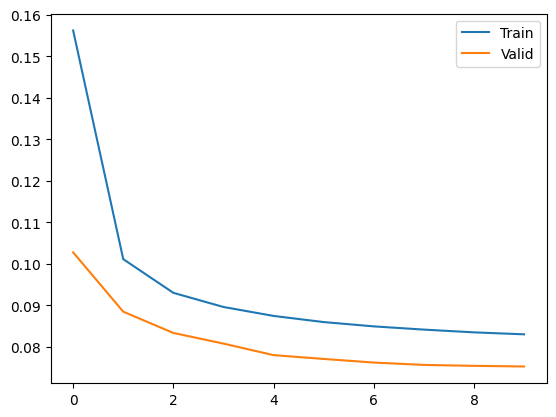

In [ ]:
# criterion = nn.MSELoss()
criterion = nn.BCELoss()

params_to_update = model.parameters()
optimizer = optim.Adam(params_to_update, lr=0.001)
dataloaders = {'train': Tr_dataloader, 'val': Va_dataloader}
model, tr_loss_history, va_loss_history = train_AE(model, dataloaders, criterion, optimizer)

plt.plot(tr_loss_history, label="Train")
plt.plot(va_loss_history, label="Valid")
plt.legend()
plt.show()

In [ ]:
error = 0.0
model.to('cpu')
model.eval()
for inputs, labels in Ts_dataloader:
    dim = inputs.shape
    target = model(inputs + torch.randn(dim) * 0.25)
    loss = criterion(target,inputs)
    error += loss.item() * inputs.size(0)

print('Testing error: {:4f}'.format(error/len(Ts_dataloader.dataset)))

Testing error: 0.082940


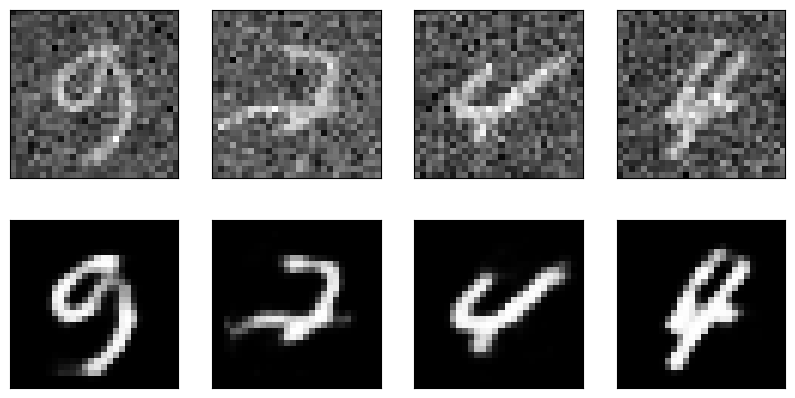

In [ ]:
dataiter = iter(Ts_dataloader)

model.eval()
n = 4
inputs, labels = next(dataiter)
plt.figure(figsize=(10, 5))
for i in range(n):
    dim = inputs[i].shape
    X = inputs[i] + torch.randn(dim) * 0.25

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X.numpy().squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)

    plt.imshow(model(X.reshape(1,dim[0],dim[1],dim[2])).detach().cpu().numpy().squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

##Variational autoencoder

A variational autoencoder (VAE) is a kind of neural networks proposed by D. P. Kingma and M. Welling.
VAE belongs to the families of probabilistic graphical models and variational Bayesian approaches.

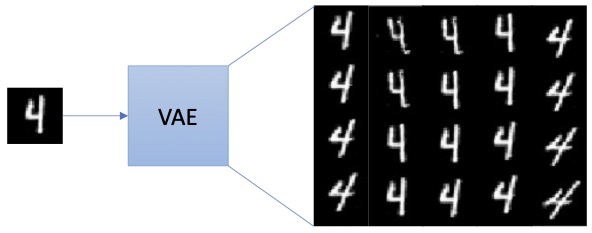

VAE shares architectural similarities with the autoencoder model, however there are significant differences in the mathematical formulation and code layer.


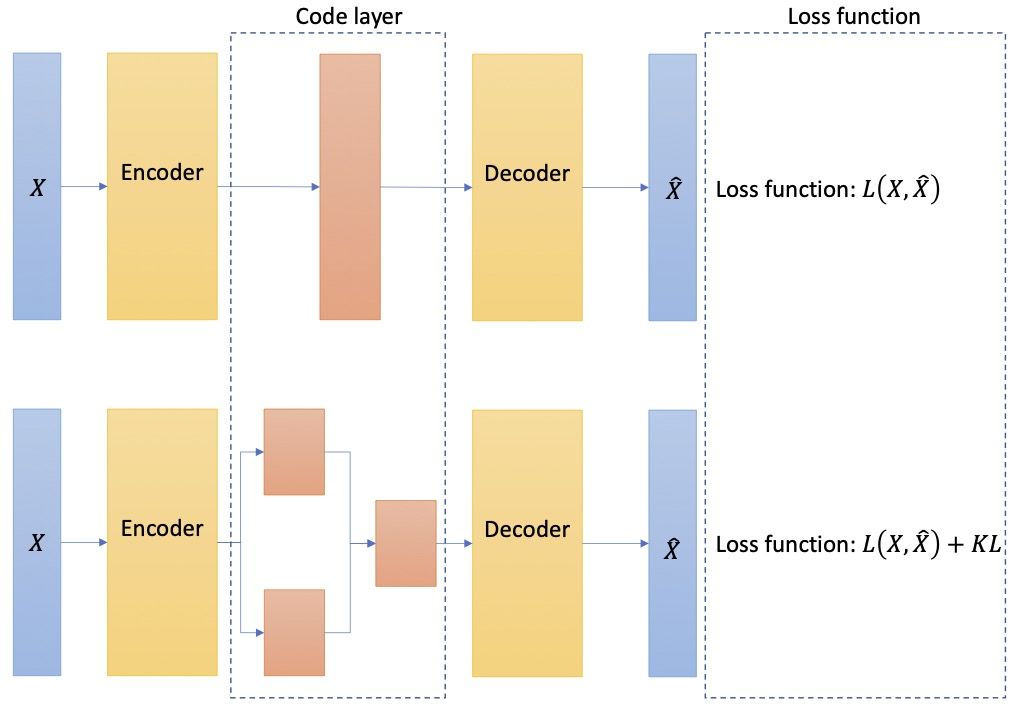

The detailed architecture of VAE is given as follows:

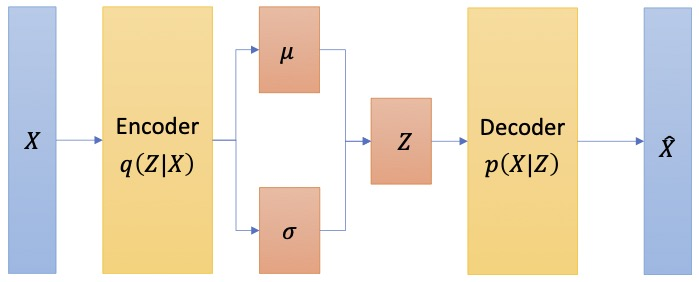

where $q(Z|X)$ is a probabilistic encoder and $p(X|Z)$ is a probabilistic decoder.
Here, $L(X,\hat{X})$ is the reconstruction loss function and $KL$ is the Kulback-Leibler (KL) divergence.

The KL divergence is a measure of difference between two probability distributions, which can be mathematical written as

\begin{align}
KL &= D_{KL}(q(Z|X) \| N(0,1))\\
&=-0.5 \sum^{d}_{j=1} 1+\log{\sigma^{2}_{j}}-\mu^{2}_{j}-\sigma^{2}_{j}
\end{align}


where $N(0,1)$ is the normal distribution with mean 0 and variance 1.


The KL-divergence measures the divergence between a pair of probability distributions, in this case, the pair of distributions being the latent vector $Z$ and $N(0, 1)$.
The KL-divergence ensures that the latent-variables are close to the standard normal distribution.
The latent vector $Z$ can be calculate as
\begin{align}
Z = \mu + \sigma \odot \varepsilon
\end{align}
where $\varepsilon$ is a normally distributed random variable and $\odot$ is element-wise multiplication.

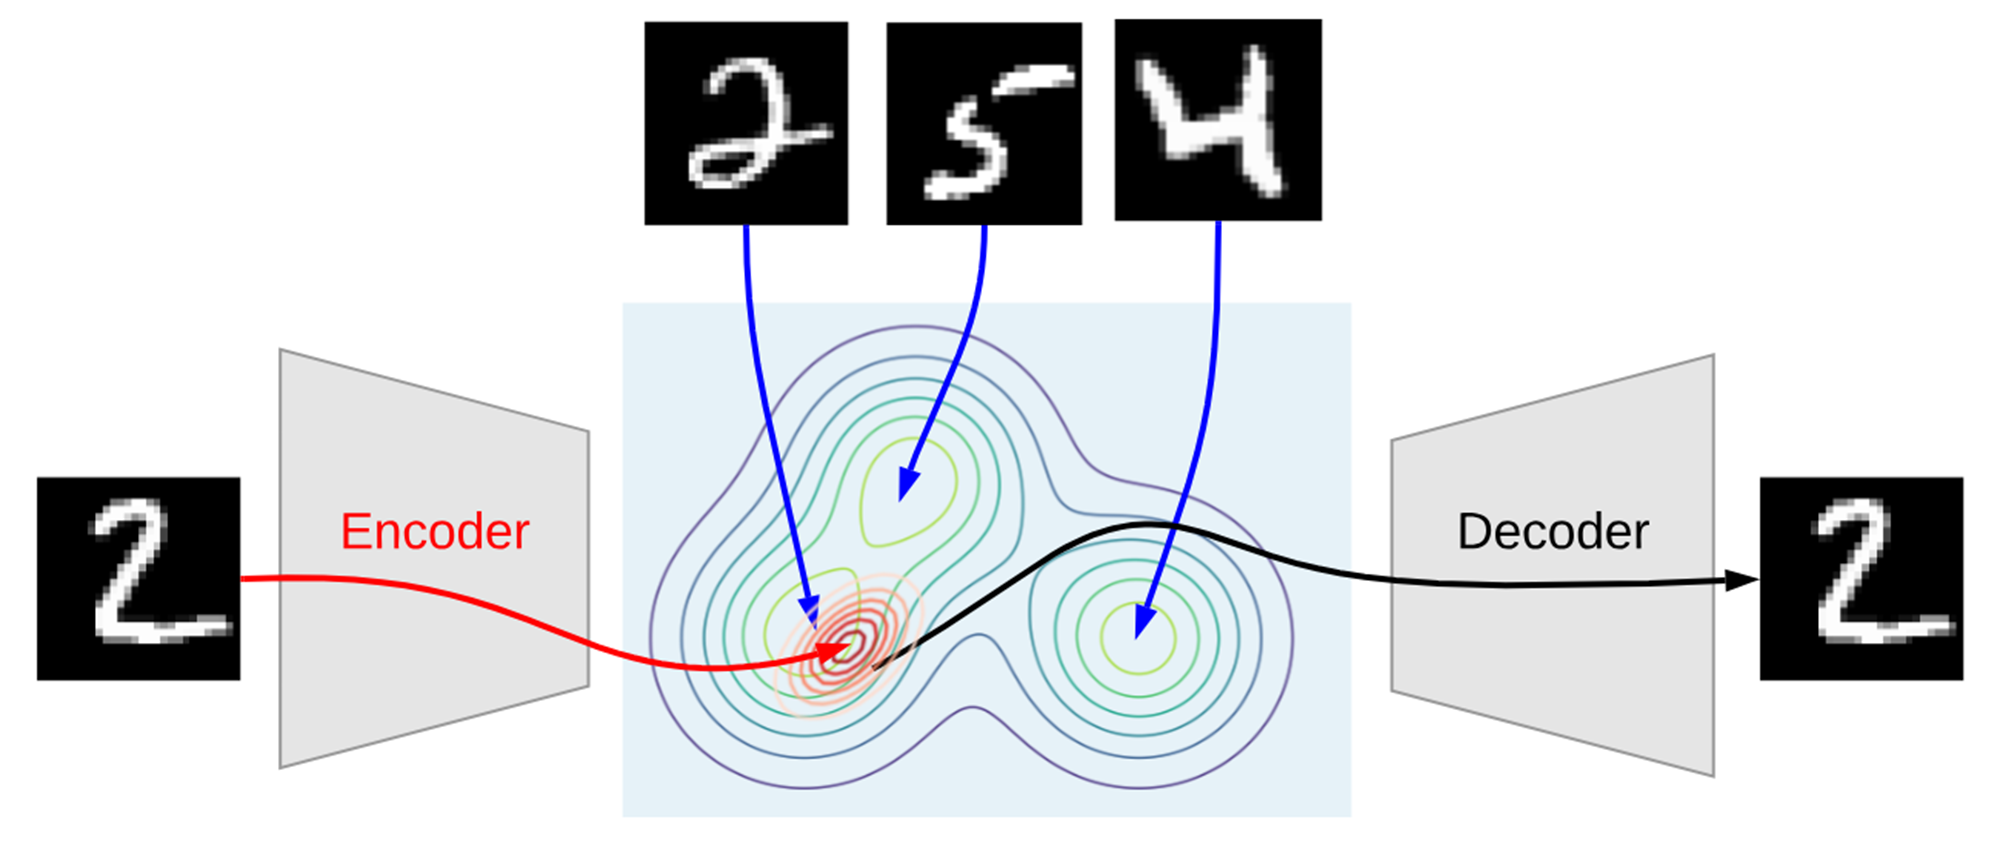

In [ ]:
class VAE(nn.Module):

    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU()
            )

        # latent mean and variance
        self.mu = nn.Linear(200, latent_dim)
        self.sigma = nn.Linear(200, latent_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 784),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x.view(-1,784))
        return self.mu(x), self.sigma(x)

    def reparameterization(self, mu, sigma):
        epsilon = torch.randn_like(sigma).to(device)
        z = mu + sigma*epsilon
        return z

    def decode(self, x):
        return self.decoder(x).view(-1,1,28,28)

    def forward(self, x):
        mu, sigma = self.encode(x)
        z = self.reparameterization(mu, sigma)
        x_hat = self.decode(z)
        return x_hat, mu, sigma

model = VAE().to(device)

In [ ]:
def train_VAE(model, dataloaders, criterion, optimizer, num_epochs=10):
    #Implement here
    start = time.time()

    va_loss_history = []
    tr_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val = np.inf

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Implement your loss function here.
                    outputs, mu, sigma = model(inputs)
                    kl_divergence = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
                    loss = criterion(outputs, inputs) + kl_divergence

                    # loss = criterion(outputs, inputs)

                    # Backpropagate only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Gather our summary statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_end = time.time()

            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            print("Epoch time taken: ", elapsed_epoch)

            # If this is the best model on the validation set so far, deep copy it
            if phase == 'val' and epoch_loss < best_val:
                best_val = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                va_loss_history.append(epoch_loss)
            if phase == 'train':
                tr_loss_history.append(epoch_loss)

        print()

    # Output summary statistics, load the best weight set, and return results

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validate Loss: {:4f}'.format(best_val))
    model.load_state_dict(best_model_wts)
    return model, tr_loss_history, va_loss_history

Epoch 0/19
----------
train Loss: 10920.4550
Epoch time taken:  10.262534856796265
val Loss: 9889.1117
Epoch time taken:  11.09440803527832

Epoch 1/19
----------
train Loss: 9653.7041
Epoch time taken:  10.901012182235718
val Loss: 9461.7291
Epoch time taken:  11.85062575340271

Epoch 2/19
----------
train Loss: 9301.7910
Epoch time taken:  9.303117513656616
val Loss: 9219.2388
Epoch time taken:  10.489873170852661

Epoch 3/19
----------
train Loss: 9102.4625
Epoch time taken:  9.904185771942139
val Loss: 9047.8532
Epoch time taken:  10.723365545272827

Epoch 4/19
----------
train Loss: 8981.8471
Epoch time taken:  10.105552911758423
val Loss: 8957.5454
Epoch time taken:  10.922929286956787

Epoch 5/19
----------
train Loss: 8891.1907
Epoch time taken:  9.969213247299194
val Loss: 8875.0945
Epoch time taken:  10.788628578186035

Epoch 6/19
----------
train Loss: 8822.5216
Epoch time taken:  10.016728401184082
val Loss: 8874.5459
Epoch time taken:  10.846159934997559

Epoch 7/19
------

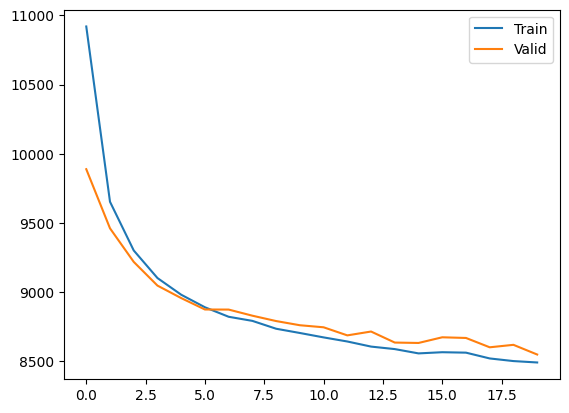

In [ ]:
# criterion = nn.MSELoss(reduction='sum')
criterion = nn.BCELoss(reduction='sum')
params_to_update = model.parameters()
optimizer = optim.Adam(params_to_update, lr=0.001)
dataloaders = {'train': Tr_dataloader, 'val': Va_dataloader}
model, tr_loss_history, va_loss_history = train_VAE(model, dataloaders, criterion, optimizer, 20)

plt.plot(tr_loss_history, label="Train")
plt.plot(va_loss_history, label="Valid")
plt.legend()
plt.show()

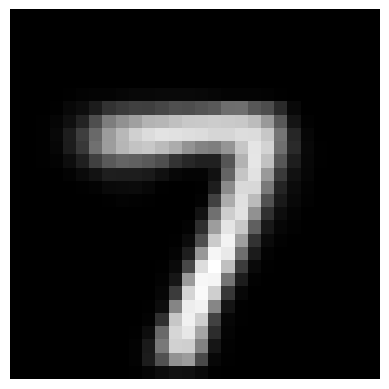

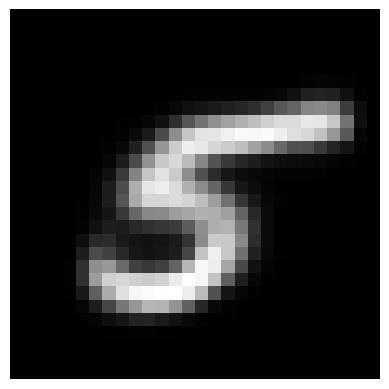

In [ ]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28)
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(-1.0, 1.0)
generate_digit(1.0, -1.0)

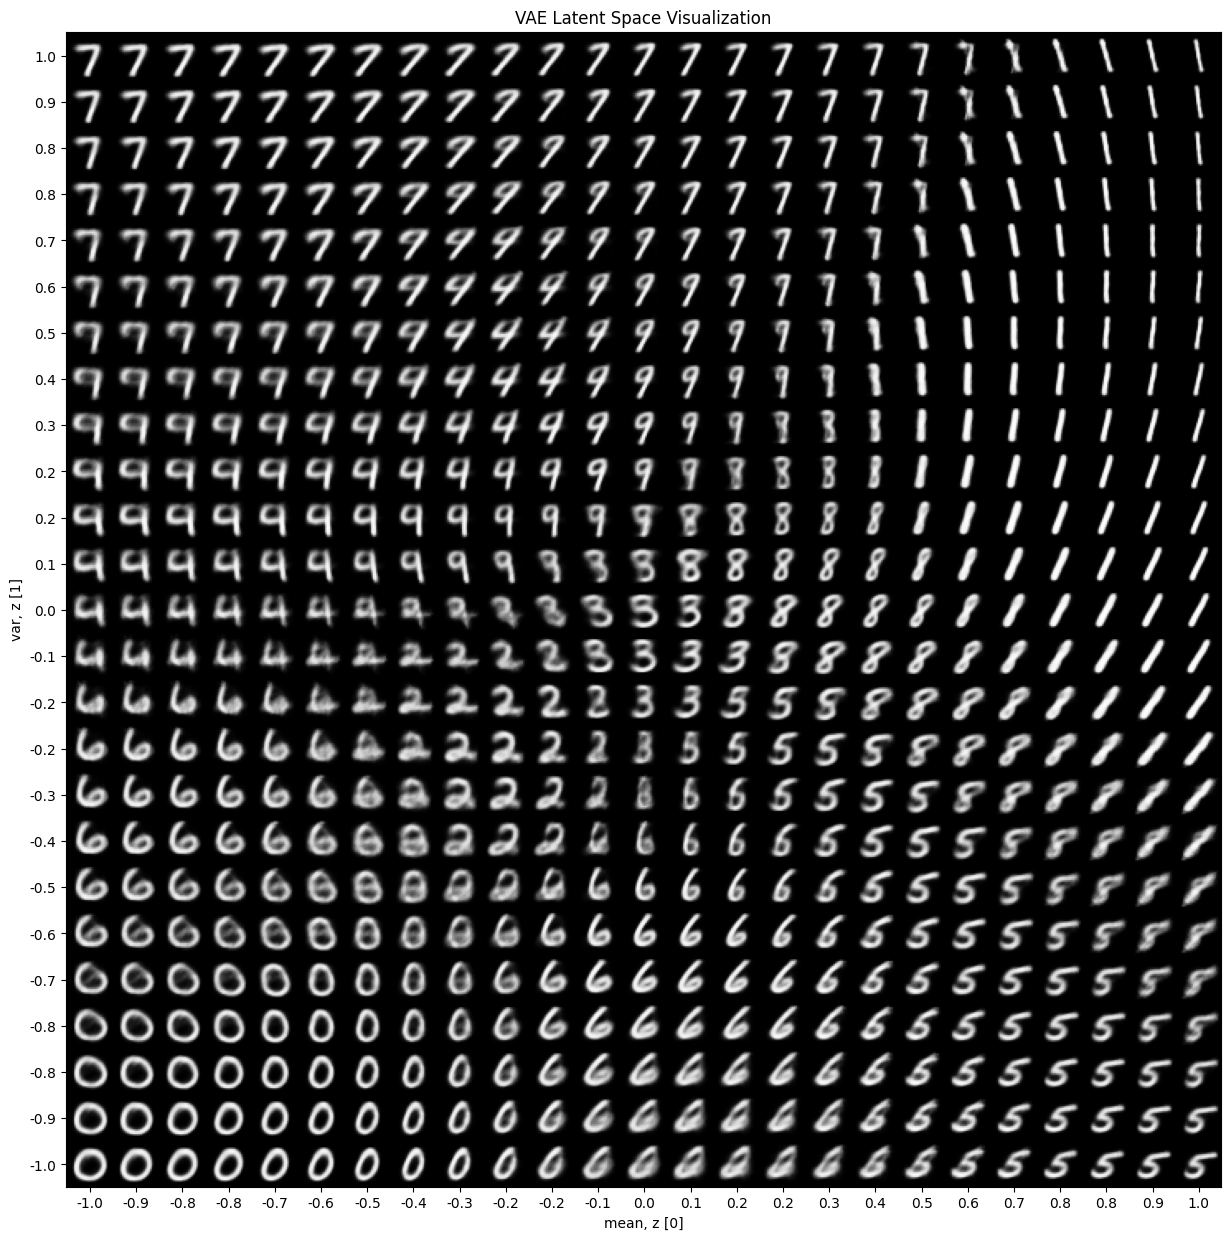

In [ ]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

#Workshop


1. Create a denoise autoencoder using convolutional layers.

2. Create a variational autoencoder using convolutional layers.


### Denoising AE workshop

In [ ]:

class DenoiseAutoencoder(nn.Module):
    def __init__(self,**kwargs):
        super(DenoiseAutoencoder,self).__init__(**kwargs)

        self.encoder = nn.Sequential(
            nn.Conv2d(NUM_CHANNEL, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, NUM_CHANNEL, 2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        if self.training:
            dim = x.shape
            x = x + torch.randn(dim).to(device) * 0.25
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Move model to target device
model = DenoiseAutoencoder().to(device)

# Show the details of the network
summary(model, input_size=(NUM_CHANNEL,width,height), device=device.type)





----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4            [-1, 8, 14, 14]           1,160
              ReLU-5            [-1, 8, 14, 14]               0
         MaxPool2d-6              [-1, 8, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]             528
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 1,913
Trainable params: 1,913
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.01
Estimated Total

Epoch 0/9
----------
train Loss: 0.7020
Epoch time taken:  11.351052045822144
val Loss: 0.6960
Epoch time taken:  12.17154598236084

Epoch 1/9
----------
train Loss: 0.6932
Epoch time taken:  10.519224405288696
val Loss: 0.6946
Epoch time taken:  12.060393571853638

Epoch 2/9
----------
train Loss: 0.6931
Epoch time taken:  9.73799729347229
val Loss: 0.6940
Epoch time taken:  10.552228212356567

Epoch 3/9
----------
train Loss: 0.6931
Epoch time taken:  9.792452096939087
val Loss: 0.6937
Epoch time taken:  10.591112852096558

Epoch 4/9
----------
train Loss: 0.6931
Epoch time taken:  11.228793144226074
val Loss: 0.6936
Epoch time taken:  12.042685747146606

Epoch 5/9
----------
train Loss: 0.6931
Epoch time taken:  8.864598989486694
val Loss: 0.6935
Epoch time taken:  9.94848918914795

Epoch 6/9
----------
train Loss: 0.6931
Epoch time taken:  9.536804437637329
val Loss: 0.6934
Epoch time taken:  10.336735963821411

Epoch 7/9
----------
train Loss: 0.6931
Epoch time taken:  9.701282262

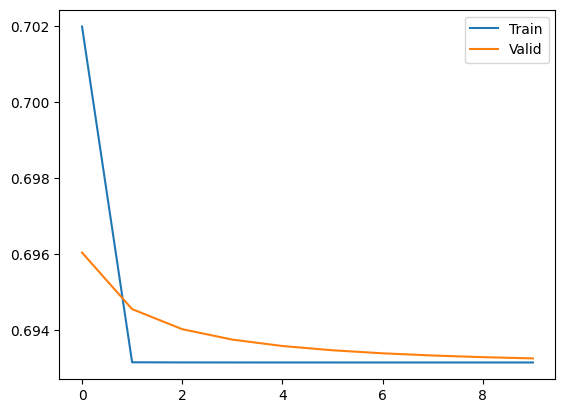

In [ ]:

# criterion = nn.MSELoss()
criterion = nn.BCELoss()

params_to_update = model.parameters()
optimizer = optim.Adam(params_to_update, lr=0.001)
dataloaders = {'train': Tr_dataloader, 'val': Va_dataloader}
model, tr_loss_history, va_loss_history = train_AE(model, dataloaders, criterion, optimizer)

plt.plot(tr_loss_history, label="Train")
plt.plot(va_loss_history, label="Valid")
plt.legend()
plt.show()





In [ ]:
error = 0.0
model.to('cpu')
model.eval()
for inputs, labels in Ts_dataloader:
    dim = inputs.shape
    target = model(inputs + torch.randn(dim) * 0.25)
    loss = criterion(target,inputs)
    error += loss.item() * inputs.size(0)

print('Testing error: {:4f}'.format(error/len(Ts_dataloader.dataset)))

Testing error: 0.693147


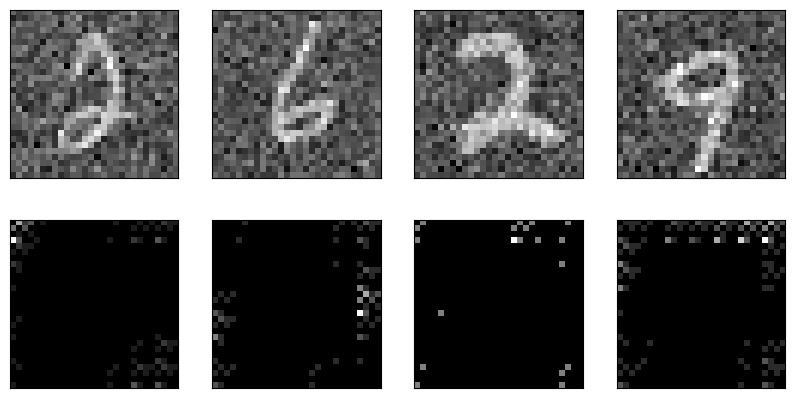

In [ ]:
dataiter = iter(Ts_dataloader)

model.eval()
n = 4
inputs, labels = next(dataiter)
plt.figure(figsize=(10, 5))
for i in range(n):
    dim = inputs[i].shape
    X = inputs[i] + torch.randn(dim) * 0.25

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X.numpy().squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)

    plt.imshow(model(X.reshape(1,dim[0],dim[1],dim[2])).detach().cpu().numpy().squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### VAE workshop

In [ ]:
class VAE(nn.Module):

    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Flatten()
            )

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2048),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride = 2, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride = 2, padding = 1),
            nn.ReLU(),
            )

        # latent mean and variance
        self.mu = nn.Linear(2048, latent_dim)
        self.sigma = nn.Linear(2048, latent_dim)

    def encode(self, x):
        x = self.encoder(x)
        return self.mu(x), self.sigma(x)

    def reparameterization(self, mu, sigma):
        epsilon = torch.randn_like(sigma).to(device)
        z = mu + sigma*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mu, sigma = self.encode(x)
        z = self.reparameterization(mu, sigma)
        x_hat = self.decode(z)
        return x_hat, mu, sigma

model = VAE().to(device)
summary(model, input_size=(NUM_CHANNEL,width,height), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
              ReLU-2           [-1, 32, 14, 14]               0
            Conv2d-3             [-1, 64, 7, 7]          18,496
              ReLU-4             [-1, 64, 7, 7]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
              ReLU-6            [-1, 128, 4, 4]               0
           Flatten-7                 [-1, 2048]               0
            Linear-8                    [-1, 2]           4,098
            Linear-9                    [-1, 2]           4,098
           Linear-10                 [-1, 2048]           6,144
        Unflatten-11            [-1, 128, 4, 4]               0
  ConvTranspose2d-12             [-1, 64, 7, 7]          73,792
             ReLU-13             [-1, 64, 7, 7]               0
  ConvTranspose2d-14           [-1, 32,

In [ ]:
# class VAE(nn.Module):

#     def __init__(self, latent_dim=2):
#         super(VAE, self).__init__()

#         # encoder
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Flatten(),
#             )
#         # decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(2, 2048),
#             nn.Unflatten(1,(128,4,4)),
#             nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
#             nn.Sigmoid(),
#             )

#         # latent mean and variance
#         self.mu = nn.Linear(2048, latent_dim)
#         self.sigma = nn.Linear(2048, latent_dim)

#     def encode(self, x):
#         x = self.encoder(x)
#         return self.mu(x), self.sigma(x)

#     def reparameterization(self, mu, sigma):
#         epsilon = torch.randn_like(sigma).to(device)
#         z = mu + sigma*epsilon
#         return z

#     def decode(self, x):
#         return self.decoder(x)

#     def forward(self, x):
#         mu, sigma = self.encode(x)
#         z = self.reparameterization(mu, sigma)
#         x_hat = self.decode(z)
#         return x_hat, mu, sigma

# model = VAE().to(device)

# summary(model, input_size=(NUM_CHANNEL,width,height), device=device.type)

In [ ]:
# #Denoising AE workshop
# class DenoisingAutoencoder(nn.Module):
#     def __init__(self,**kwargs):
#         super(DenoisingAutoencoder,self).__init__(**kwargs)
#         self.encoder = nn.Sequential(
#             nn.Conv2d(NUM_CHANNEL, 16, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#             nn.Conv2d(16, 8, 3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2, 2),
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(8, 16, 2, stride=2),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, NUM_CHANNEL, 2, stride=2),
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         if self.training:
#             x = x + torch.randn(x.shape).to(device) * 0.25
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

# # Move model to target device
# model = DenoisingAutoencoder().to(device)

# # Show the details of the network
# summary(model, input_size=(NUM_CHANNEL,width,height), device=device.type)